In [1]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset

block_size = 3
X, Y = [], []
for w in words:

    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
# build the dataset

def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
    
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
C = torch.randn((27,2))

In [8]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [9]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [10]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1)

In [11]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [12]:
logits = h @ W2 + b2

In [13]:
logits.shape

torch.Size([228146, 27])

In [14]:
counts = logits.exp()

In [15]:
prob = counts / counts.sum(1, keepdims=True)

In [ ]:
# ------ refactored ------

In [200]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [273]:
# g = torch.Generator().manual_seed(2147483647)
# C = torch.randn((27,10), generator=g)
# W1 = torch.randn((30, 200), generator=g)
# b1 = torch.randn(200, generator=g)
# W2 = torch.randn((200,27), generator=g)
# b2 = torch.randn(27, generator=g)
# parameters = [C, W1, b1, W2, b2]

# looks like a better initialization <- no peak at the beginnig, training looks smooth 
scale = 0.2
shift = -scale/2

g = torch.Generator().manual_seed(2147483647+1)
C = torch.rand((27,10), generator=g) * scale + shift
W1 = torch.rand((30, 200), generator=g) * scale + shift
b1 = torch.rand(200, generator=g) * scale + shift
W2 = torch.rand((200,27), generator=g) * scale + shift
b2 = torch.rand(27, generator=g) * scale + shift
parameters = [C, W1, b1, W2, b2]

In [274]:
W1.max()

tensor(0.1000)

In [275]:
sum(p.nelement() for p in parameters)

11897

In [276]:
for p in parameters:
    p.requires_grad = True

In [277]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [278]:
lri = []
lossi = []
stepi = []

In [279]:
for i in range(600000):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.log().item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.1 if i < 200000 else 0.01 
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())


In [280]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0698, grad_fn=<NllLossBackward0>)

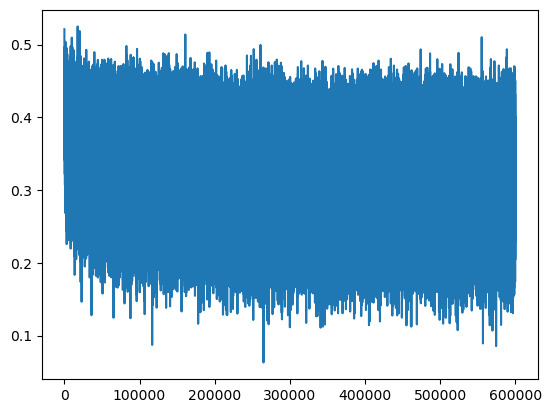

In [281]:
plt.plot(stepi, lossi)

In [282]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1197, grad_fn=<NllLossBackward0>)

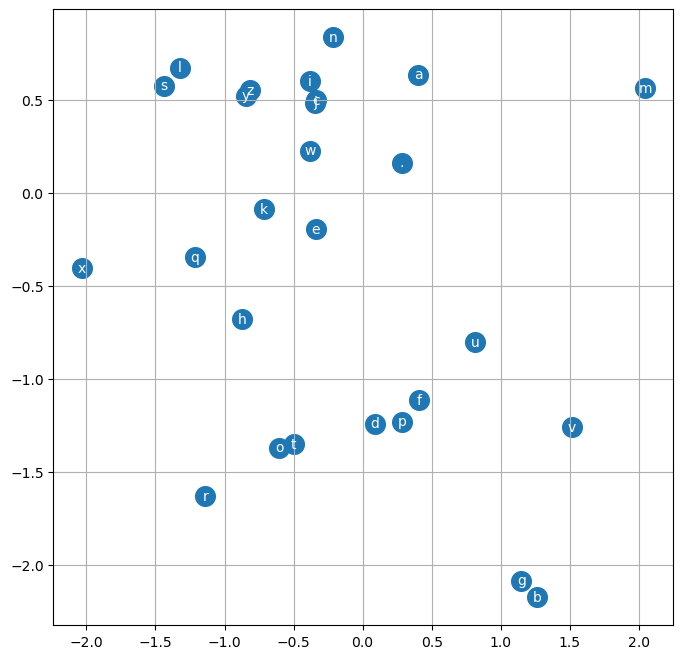

In [241]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i, 1].item(), itos[i], ha='center', va='center', color='white')
plt.grid(True)

In [ ]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [221]:
new_logits = torch.ones((182625, 27)) / 27
F.cross_entropy(new_logits, Ytr).log10()

tensor(0.5180)

In [192]:
torch.rand([1]) * 0.2 - 0.1

tensor([-0.0069])